In [3]:
from warnings import simplefilter

import numpy as np


simplefilter(action="ignore", category=FutureWarning)

from test.helpers import (
    SDE,
    simple_batch_sde_solve,
)

import diffrax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    Euler,
    SaveAt,
    SpaceTimeTimeLevyArea,
)
from talay import Talay
from talay_controller import TalayController
from weak_sde import get_weak_sde, weak_error


jax.config.update("jax_enable_x64", True)


def draw_order(results_dict):
    fig, ax = plt.subplots()
    fig.set_dpi(100)

    orders = "Orders:\n"
    scats = []
    for i, (name, result) in enumerate(results_dict.items()):
        steps, errs, slice = result
        steps = steps[slice]
        errs = errs[slice]
        trend = np.polyfit(-np.log(steps), np.log(errs), 1)
        order, _ = trend
        # plot the trend line
        # trend_f = np.poly1d(trend)
        # ax.plot(steps, np.exp(trend_f(-np.log(steps))), linewidth=1.0)

        # plot the points
        scat = ax.scatter(
            steps,
            errs,
            label=f"{name}: {order:.2f}",
        )
        scats.append(scat)

        orders += f"{name}: {order:.2f}\n"
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("RMS error")
    ax.set_xlabel("Average number of vector field evaluations")
    ax.legend(fancybox=True, fontsize="large")
    plt.show()


t0 = 0.0
t1 = 3.0
saveat = SaveAt(t1=True)
constant_controller = diffrax.ConstantStepSize()
# sde: SDE = get_mlp_sde(t0, t1, jnp.float64, jr.key(0), 5, y_dim=4)
sde: SDE = get_weak_sde(t0, t1, jnp.float64)

num_samples = 1000000
keys = jr.split(jr.key(0), num_samples)
sde_name = "weak"

In [4]:
ref_filename = f"data/ref_sol_{sde_name}_{num_samples//1000}k.npy"

# ref_sols, ref_steps = simple_batch_sde_solve(
#     keys,
#     sde,
#     Euler(),
#     BrownianIncrement,
#     2**-12,
#     constant_controller,
#     0,
#     saveat,
#     use_progress_meter=True,
#     use_vbt=False,
# )
# jnp.save(ref_filename, ref_sols)

ref_sols = jnp.load(ref_filename)
# ref_funs = compute_test_functions(ref_sols)
ref_errs = weak_error(ref_sols, t0, t1)
print(ref_errs)

3.697603897859225e-06


In [5]:
def evaluate_solve(solver, dt, controller):
    sols, steps = simple_batch_sde_solve(
        keys,
        sde,
        solver,
        SpaceTimeTimeLevyArea,
        dt,
        controller,
        0,
        saveat,
        use_progress_meter=True,
        use_vbt=False,
    )

    # errors = comp_fun_dist(sols, ref_funs)
    errors = weak_error(sols, t0, t1)
    return errors, jnp.mean(steps)

In [22]:
dts = [0.5**i for i in range(0, 8)]
errors_euler = []
steps_euler = []

for dt in dts:
    print(f"dt = {dt}")
    errors_, steps_ = evaluate_solve(Euler(), dt, constant_controller)
    errors_euler.append(errors_)
    steps_euler.append(steps_)

errors_euler = jnp.array(errors_euler)
steps_euler = jnp.array(steps_euler)
with open(f"data/errors_{sde_name}_sde_euler.npy", "wb") as f:
    jnp.save(f, errors_euler)
    jnp.save(f, steps_euler)

with open(f"data/errors_{sde_name}_sde_euler.npy", "rb") as f:
    errors_euler = jnp.load(f)
    steps_euler = jnp.load(f)

dt = 1.0


100.00%|██████████| [00:00<00:00, 5776.48%/s]


dt = 0.5


100.00%|██████████| [00:00<00:00, 3046.57%/s]


dt = 0.25


100.00%|██████████| [00:00<00:00, 1583.83%/s]


dt = 0.125


100.00%|██████████| [00:00<00:00, 796.31%/s]


dt = 0.0625


100.00%|██████████| [00:00<00:00, 557.73%/s]


dt = 0.03125


100.00%|██████████| [00:00<00:00, 281.28%/s]


dt = 0.015625


100.00%|██████████| [00:00<00:00, 140.46%/s]


dt = 0.0078125


100.00%|██████████| [00:01<00:00, 70.67%/s]


In [23]:
dts = [0.5**i for i in range(0, 8)]
errors_talay_const = []
steps_talay_const = []

for dt in dts:
    print(f"dt = {dt}")
    errors_, steps_ = evaluate_solve(Talay(jr.key(7)), dt, constant_controller)
    errors_talay_const.append(errors_)
    steps_talay_const.append(steps_)

errors_talay_const = jnp.array(errors_talay_const)
steps_talay_const = jnp.array(steps_talay_const)
with open(f"data/errors_{sde_name}_sde_talay_const.npy", "wb") as f:
    jnp.save(f, errors_talay_const)
    jnp.save(f, steps_talay_const)

with open(f"data/errors_{sde_name}_sde_talay_const.npy", "rb") as f:
    errors_talay_const = jnp.load(f)
    steps_talay_const = jnp.load(f)

dt = 1.0


100.00%|██████████| [00:00<00:00, 2872.54%/s]


dt = 0.5


100.00%|██████████| [00:00<00:00, 1488.39%/s]


dt = 0.25


100.00%|██████████| [00:00<00:00, 745.11%/s]


dt = 0.125


100.00%|██████████| [00:00<00:00, 371.34%/s]


dt = 0.0625


100.00%|██████████| [00:00<00:00, 187.20%/s]


dt = 0.03125


100.00%|██████████| [00:01<00:00, 93.42%/s]


dt = 0.015625


100.00%|██████████| [00:02<00:00, 46.74%/s]


dt = 0.0078125


100.00%|██████████| [00:04<00:00, 23.41%/s]


In [25]:
ctols = [0.5**i for i in range(4, 16)]
errors_talay_adaptive = []
steps_talay_adaptive = []

for ctol in ctols:
    solver = Talay(jr.key(7), error_mult=ctol, use_levy_area=True)
    controller = TalayController(ctol, dtmin=2**-10, dtmax=4.0)
    print(f"ctol = {ctol}")
    errors_, steps_ = evaluate_solve(solver, 1.0, controller)
    errors_talay_adaptive.append(errors_)
    steps_talay_adaptive.append(steps_)

errors_talay_adaptive = jnp.array(errors_talay_adaptive)
steps_talay_adaptive = jnp.array(steps_talay_adaptive)
with open(f"data/errors_{sde_name}_sde_talay_adaptive.npy", "wb") as f:
    jnp.save(f, errors_talay_adaptive)
    jnp.save(f, steps_talay_adaptive)

with open(f"data/errors_{sde_name}_sde_talay_adaptive.npy", "rb") as f:
    errors_talay_adaptive = jnp.load(f)
    steps_talay_adaptive = jnp.load(f)

ctol = 0.0625


100.00%|██████████| [00:00<00:00, 1649.39%/s]


ctol = 0.03125


100.00%|██████████| [00:00<00:00, 1289.58%/s]


ctol = 0.015625


100.00%|██████████| [00:00<00:00, 855.44%/s] 

ctol = 0.0078125

100.00%|██████████| [00:00<00:00, 575.79%/s]


ctol = 0.00390625


100.00%|██████████| [00:00<00:00, 271.11%/s]


ctol = 0.001953125


100.00%|██████████| [00:00<00:00, 205.78%/s]


ctol = 0.0009765625


100.00%|██████████| [00:00<00:00, 104.30%/s]


ctol = 0.00048828125


100.00%|██████████| [00:02<00:00, 41.49%/s]


ctol = 0.000244140625


100.00%|██████████| [00:04<00:00, 21.01%/s]


ctol = 0.0001220703125


100.00%|██████████| [00:08<00:00, 11.35%/s]


ctol = 6.103515625e-05


100.00%|██████████| [00:16<00:00,  5.92%/s]


ctol = 3.0517578125e-05


100.00%|██████████| [00:33<00:00,  3.02%/s]


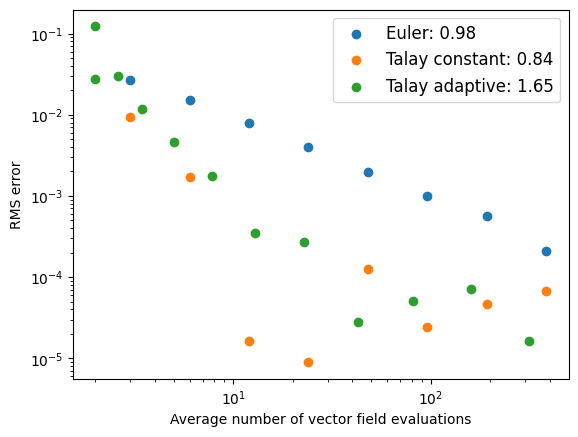

In [26]:
draw_order(
    {
        "Euler": (steps_euler, errors_euler, slice(None, None)),
        "Talay constant": (steps_talay_const, errors_talay_const, slice(None, None)),
        "Talay adaptive": (
            steps_talay_adaptive,
            errors_talay_adaptive,
            slice(None, None),
        ),
    }
)